# Stable Paths - Recommendation Systems

We construct a Steinhaus Mapper filtration on the MovieLens-20M dataset. We then investigate stable paths in the graph to find the "smoothest" transition between two movies.

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
# Relative path to the MovieLens-20M dataset.
path_to_ml_20m = "./data/ml-20m/"

In [3]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import itertools
import time
import umap
import paths

# Steinhaus Filtration Class

The `Cover` class constructs the Steinhaus filtration (under Jaccard measure) given a set of covers.

In [18]:
class BaseFiltration:
    def __init__(self, max_dim=3):
        self.max_dim = max_dim
        
        
class Cover(BaseFiltration):
    def build(self, covers):
        # Give each cover element a name.
        if not isinstance(covers, dict):
            covers = dict(enumerate(covers))

        simplices = [([k], 0.0) for k in covers.keys()]

        #Changed self.max_dim+1 to self.max_dim+2. Correct?
        for k in range(2, self.max_dim + 2):
            for potentials in itertools.combinations(covers.keys(), k):
                potential_sets = [covers[p] for p in potentials]

                d = self.jaccard(potential_sets)

                if d < 1:
                    simplices.append((potentials, d))

        return simplices

    def jaccard(self, covers):
        covers_as_sets = list(map(set, covers))
        intersection = set.intersection(*covers_as_sets)
        union = set.union(*covers_as_sets)

        return 1 - len(intersection) / len(union)


__all__ = ['Cover']

%matplotlib inline

pd.options.display.max_rows = 8

# Load the ratings and movie datasets

In [17]:
ratings = pd.read_csv(os.path.join(path_to_ml_20m, "ratings.csv"), delimiter=",")\
            .drop(columns=['timestamp'])
ratings = ratings.loc[ratings['rating']>= 3.5]
ratings

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
...,...,...,...
20000257,138493,68319,4.5
20000258,138493,68954,4.5
20000259,138493,69526,4.5
20000261,138493,70286,5.0


In [10]:
movie_info = pd.read_csv(os.path.join(path_to_ml_20m, "movies.csv"), delimiter=",")
movie_info

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
...,...,...,...
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)
27277,131262,Innocence (2014),Adventure|Fantasy|Horror


In [19]:
# Helper fumction for looking up a movie's index based on title.
def lookup_movie(title):
    return movie_info.loc[movie_info.title.str.contains(title)]["movieId"].to_list()[0]

# Construct the Pullback

Construct the `movies_map` representing the pullback of $\textup{rating}\mapsto\textup{movie}$.

In [20]:
movies = ratings.groupby('movieId')
movies_map = {name: list(group.userId) for name, group in movies}

Remove all movies with less than 10 ratings.

In [21]:
slim_movies_map = {name: ls for name, ls in movies_map.items() if len(ls) >= 10}

Construct an even smaller sample of movies by randomly sampling making sure to include a specific set of movies.

In [39]:
transformers = 53996
notebook = 8533
princess = 1197
darko = 4878
chainsaw = 6880
mulan = 1907
rouge = 4308

good_movies = [transformers, notebook, princess, darko, chainsaw, mulan, rouge]
np.random.seed(1)

rate = 200. / len(movies_map)
slimer_movies_map = {name: ls for name, ls in movies_map.items() 
                     if np.random.random() <= rate or name in good_movies}

In [13]:
for m in good_movies:
    assert m in slimer_movies_map.keys()

# Construct Steinhaus Filtration

We construct a networkx graph repesenting the Mapper graphs and assign weights giveen by the Steinhaus filtration.

In [24]:
def thresh_filt(filtration, thresh):
    filtration = [f for f in filtration if f[1] < thresh]
    return filtration
    
def build_graph(filtration, thresh=None):
    """ Build a networkx graph out of the 1-skeleton in the filtration
    """
    if thresh:
        filtration = thresh_filt(filtration, thresh)
    
    vertices = [s[0][0] for s in filtration if len(s[0]) == 1]
    edges = [s[0] for s in filtration if len(s[0]) == 2]
    edge_attrs = {s[0]: s[1] for s in filtration if len(s[0]) == 2}
    edge_weights = list(edge_attrs.values())
    
    g = nx.Graph()
    g.add_nodes_from(vertices)
    g.add_edges_from(edges)
    nx.set_edge_attributes(g, edge_attrs, 'dist')

    return g

Actually construct the graph. We keep track of the computation time.

In [ ]:
start = time.time()
c = Cover(max_dim=1)
filtration = c.build(slimer_movies_map) # Change this to slim_movies_map to use larger sample.

vertices = [s for s in filtration if len(s[0]) == 1]
edges = [s for s in filtration if len(s[0]) == 2]

# Make sure we have vertices and edges and no triangles
assert len(filtration) == len(vertices) + len(edges)
assert len(edges) > 0
g = build_graph(filtration)
end = time.time()
print(end-start)

In [ ]:
#Once a graph is generated, it can be saved and loaded through nx.write_gpickle and nx.read_gpickle. 
#nx.write_gpickle(g,'7000_sample_graph')

# Find Stable Paths

We find the stable paths between two movies and plot the Pareto Frontier.

In [33]:
def plot_pareto2(most_stable, all_stable_paths, save=False):
    unoptimal_paths = np.array([(n, s[1]) for n, ps in all_stable_paths.items() for s in ps])
    optimal_paths = np.array([(n,ps[1]) for n, ps in most_stable.items()])

    ax = plt.figure(figsize=(20,10)).gca()  
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) 
    plt.subplot(111)
    
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 

    cmap = plt.get_cmap('tab10')
    plt.scatter(unoptimal_paths[:,0], unoptimal_paths[:,1], color=cmap(1), label='Nonoptimal paths')
    plt.scatter(optimal_paths[:,0], optimal_paths[:,1], label='Optimal paths')
    plt.plot(optimal_paths[:,0], optimal_paths[:,1], label='Pareto frontier')


    plt.xlabel("Length of path")
    plt.ylabel("Instability of path")

    plt.legend()
    ticks = range(int(min(optimal_paths[:,0])), int(max(optimal_paths[:,0])) + 1)
    plt.xticks(ticks)
    if save!=False:
        plt.savefig(save,)

In [34]:
from matplotlib.ticker import MaxNLocator
import networkx as nx
from matplotlib.collections import LineCollection

def movie_names_in_path(ms):
    movies_in_path = ms[0]
    pms = [movie_info.loc[movie_info.movieId == m].title.values[0] for m in movies_in_path]
    return pms

#Set save=True when calling to save output as files
def paths_demo(g, source, terminal,save=False):
    most_stable, all_stable_paths = paths.most_stable_paths(g, source, terminal)
    plot_pareto2(most_stable, all_stable_paths, save=False)
    print(str(source))
    
    for k, p in most_stable.items():
        print(p)
        print(k, ":\n\t", "\n\t".join(movie_names_in_path(p)))
        if save==True:
            with open('Output/'+str(source)+'_'+str(terminal)+'_samples.txt', 'a+') as f:
                f.write(str(p))
                f.write(str(k)+":\n\t"+"\n\t")
                for movie in movie_names_in_path(p):
                    f.write(str(movie)+":\n\t"+"\n\t")
        

### Mulan $\to$ Moulin Rouge

1907
([1907, 4308], 0.8843980133584518)
2 :
	 Mulan (1998)
	Moulin Rouge (2001)


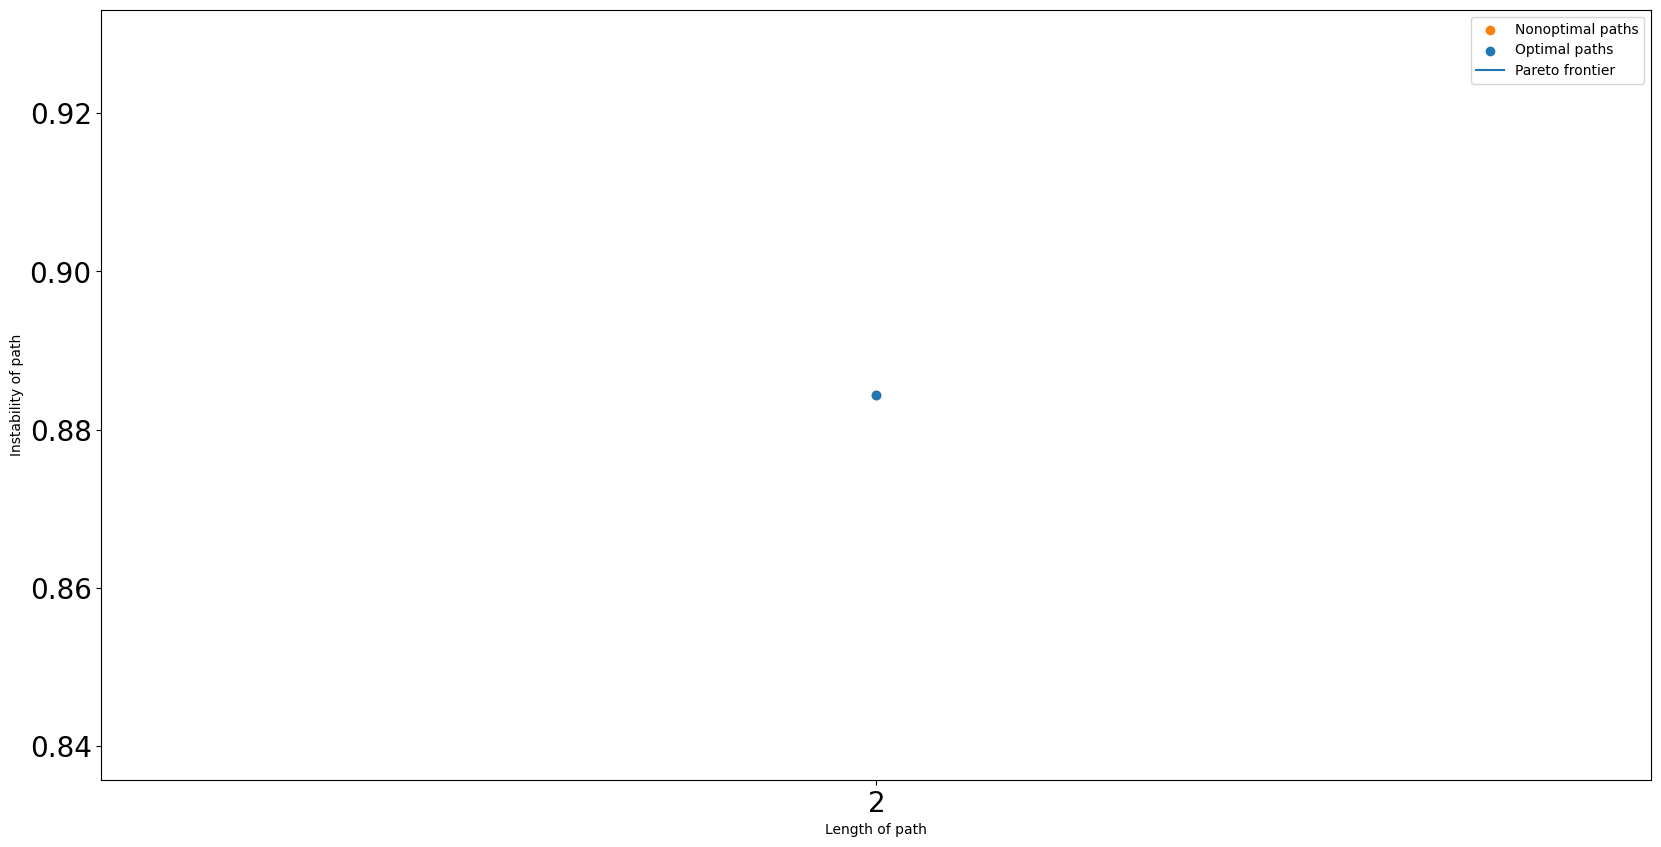

In [37]:
paths_demo(g, mulan, moulin_rouge)

### Texas Chainsaw Massacre $\to$ Mulan

6880
([6880, 1907], 0.9853811347024016)
2 :
	 Texas Chainsaw Massacre, The (2003)
	Mulan (1998)
([6880, 53996, 1907], 0.9670359362334504)
3 :
	 Texas Chainsaw Massacre, The (2003)
	Transformers (2007)
	Mulan (1998)
([6880, 4388, 53996, 1907], 0.9590760733115742)
4 :
	 Texas Chainsaw Massacre, The (2003)
	Scary Movie 2 (2001)
	Transformers (2007)
	Mulan (1998)
([6880, 4388, 3986, 1127, 1907], 0.9583858764186634)
5 :
	 Texas Chainsaw Massacre, The (2003)
	Scary Movie 2 (2001)
	6th Day, The (2000)
	Abyss, The (1989)
	Mulan (1998)


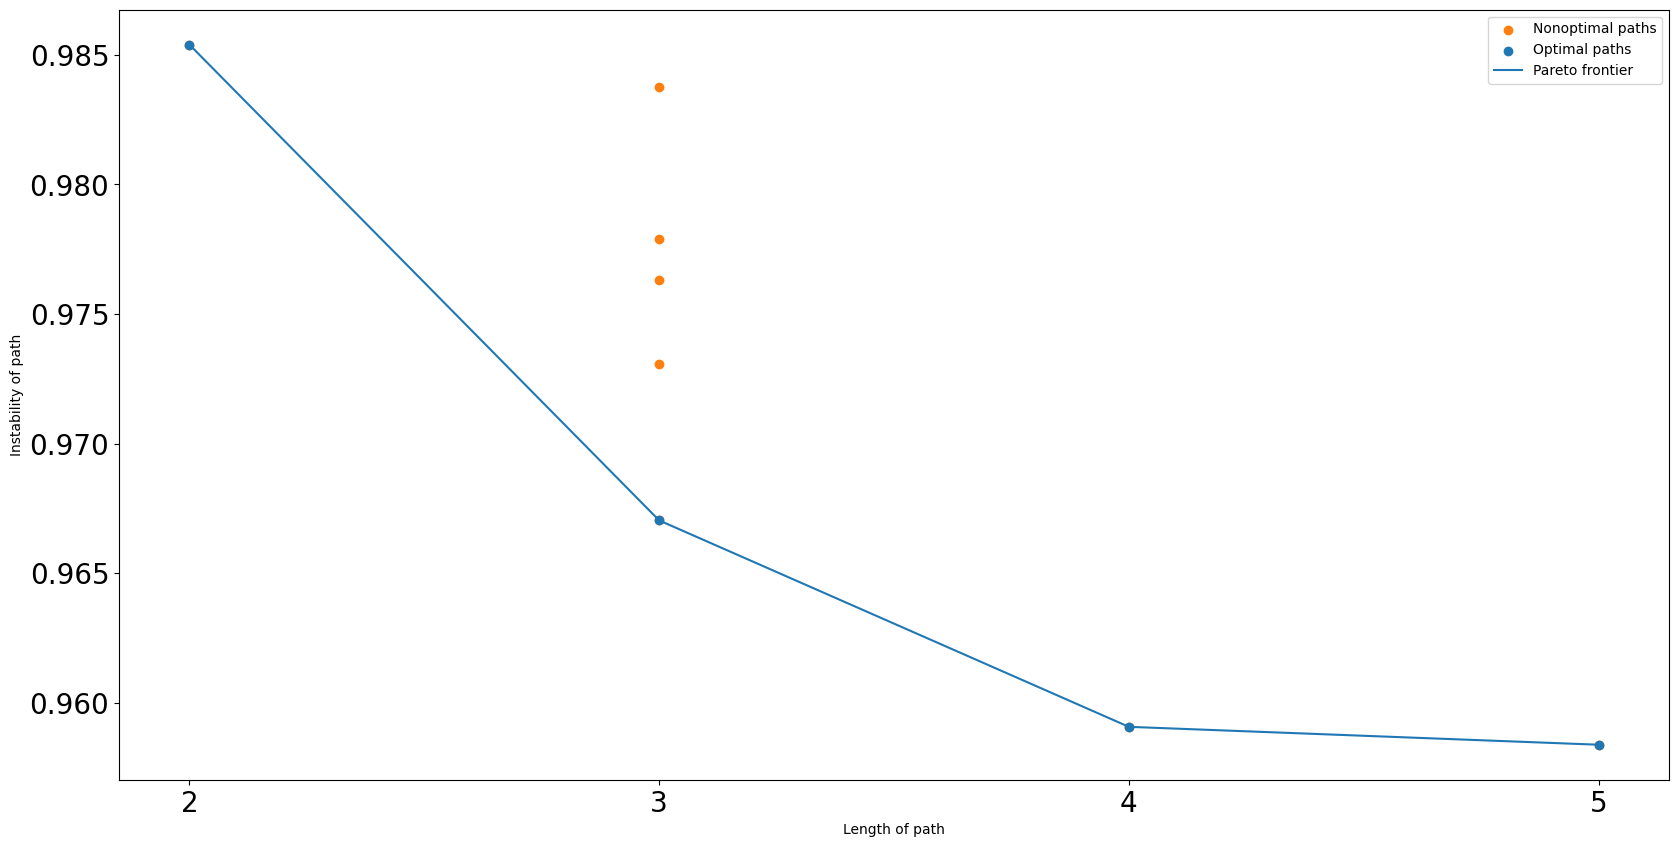

In [40]:
paths_demo(g, chainsaw, mulan)